In [3]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx


from tqdm import tqdm

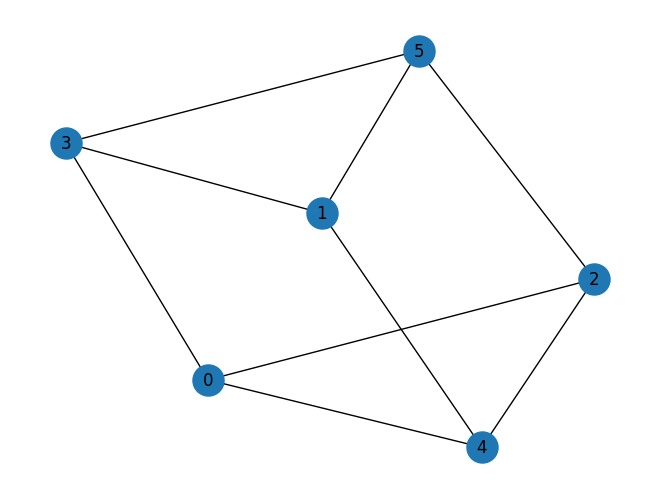

In [4]:
n = 6  # Number of nodes in the graph
G = nx.random_regular_graph(3, n)  # Generate a random graph with 3 neighbors for each node
pos = nx.spring_layout(G, seed=42) # Seed for reproducibility
nx.draw(G, pos, with_labels=True, node_size=500)

In [50]:
def init_G(d, N):
    """
    Initialize the graph G with N nodes and degree d.
    """
    G = nx.random_regular_graph(d, N)
    return G

In [79]:
def initalize_wp(G):
    N = G.number_of_nodes()
    warnings = np.random.randint(0,2,size=(N, N, 2, 2)) # warnings[i, j, :, :] is the warning from node i to node j. They take values 0 for - and 1 for +
    for i in list(G.nodes()):
        for j in list(G.nodes()):
            if (j not in list(G.neighbors(i))):
                warnings[i, j, :, :] = 0
    return warnings

def planted_initialize_wp(G): #useful for testing. this is a fixed point of +000 for sure
    N = G.number_of_nodes()
    warning = [[1, 0], [0, 0]]
    warnings = np.zeros((N, N, 2, 2))
    for i in list(G.nodes()):
        for j in list(G.neighbors(i)):
            warnings[i, j, :, :] = warning
    return warnings

def partially_planted_initialize_wp(G):
    N = G.number_of_nodes()
    warnings = np.random.randint(0,2,size=(N, N, 2, 2)) # warnings[i, j, :, :] is the warning from node i to node j. They take values 0 for - and 1 for +
    for i in list(G.nodes()):
        for j in list(G.nodes()):
            if (j not in list(G.neighbors(i))):
                warnings[i, j, :, :] = 0
            else:
                warnings[i, j, 1, 1] = 0
    return warnings

def partially_planted2_initialize_wp(G):
    N = G.number_of_nodes()
    warnings = np.random.randint(0,2,size=(N, N, 2, 2)) # warnings[i, j, :, :] is the warning from node i to node j. They take values 0 for - and 1 for +
    for i in list(G.nodes()):
        for j in list(G.nodes()):
            if (j not in list(G.neighbors(i))):
                warnings[i, j, :, :] = 0
            else:
                warnings[i, j, 1, 1] = 0
                warnings[i, j, 0, 0] = 1
    return warnings

In [55]:
def gen_configurations(d):
    """
    returns all possible configurations of d-1 neighbours
    """
    return np.array(np.meshgrid(*[[0, 1]] * (d-1))).T.reshape(-1, d-1)

In [47]:
def rule_satisfied(sigma_i, sigma_j, configuration, rule_plus):
    """
    returns True if the configuration satisfies the rule, False otherwise
    """
    if np.sum(np.concatenate((configuration, np.array([sigma_j])))*sigma_i) == 0:
        return True
    else:
        return False

In [46]:
def neighbouring_warnings_allow(sigma_i, configuration, neighbouring_warnings):
    """
    returns True if the neighbouring warnings allow the configuration, False otherwise
    """
    
    for k, warning in enumerate(neighbouring_warnings):
        sigma_k = configuration[k]
        if warning[sigma_k, sigma_i] == 0:
            return False

    return True
    

In [58]:
def warning_propagation_update(neighbouring_warnings, rule_plus):
    """
    neighbouring warnings (list): list of warnings of neighbouring nodes k except j

    returns warning i -> j (2x2 array)
    """
    d = len(neighbouring_warnings) + 1
    warning = np.zeros((2, 2))
    for sigma_i in range(2):
        for sigma_j in range(2):
            configurations = gen_configurations(d)
            for configuration in configurations:
                if rule_satisfied(sigma_i, sigma_j, configuration, rule_plus) and neighbouring_warnings_allow(sigma_i, configuration, neighbouring_warnings):
                    warning[sigma_i, sigma_j] = 1
                    break
    return warning
            
            
    

In [80]:
def warning_propagation(G, rule_plus = True, num_iters = 100):
    warnings = initalize_wp(G)
    for _ in tqdm(np.arange(num_iters)):
        for i in list(G.nodes()):
            for j in list(G.neighbors(i)):
                neighbouring_warnings = []
                for k in list(G.neighbors(i)):
                    if (k != j):
                        neighbouring_warnings.append(warnings[k, i, :, :])

                warnings[i, j, :, :] = warning_propagation_update(neighbouring_warnings, rule_plus)
    return warnings
    
def warning_propagation_planted(G, rule_plus = True, num_iters = 100):
    warnings = planted_initialize_wp(G)
    for _ in tqdm(np.arange(num_iters)):
        for i in list(G.nodes()):
            for j in list(G.neighbors(i)):
                neighbouring_warnings = []
                for k in list(G.neighbors(i)):
                    if (k != j):
                        neighbouring_warnings.append(warnings[k, i, :, :])

                warnings[i, j, :, :] = warning_propagation_update(neighbouring_warnings, rule_plus)
    return warnings

def warning_propagation_partially_planted(G, rule_plus = True, num_iters = 100):
    warnings = partially_planted_initialize_wp(G)
    for _ in tqdm(np.arange(num_iters)):
        for i in list(G.nodes()):
            for j in list(G.neighbors(i)):
                neighbouring_warnings = []
                for k in list(G.neighbors(i)):
                    if (k != j):
                        neighbouring_warnings.append(warnings[k, i, :, :])

                warnings[i, j, :, :] = warning_propagation_update(neighbouring_warnings, rule_plus)
    return warnings

def warning_propagation_partially_planted2(G, rule_plus = True, num_iters = 100):
    warnings = partially_planted2_initialize_wp(G)
    for _ in tqdm(np.arange(num_iters)):
        for i in list(G.nodes()):
            for j in list(G.neighbors(i)):
                neighbouring_warnings = []
                for k in list(G.neighbors(i)):
                    if (k != j):
                        neighbouring_warnings.append(warnings[k, i, :, :])

                warnings[i, j, :, :] = warning_propagation_update(neighbouring_warnings, rule_plus)
    return warnings


In [64]:
#Test
G = init_G(3, 100)
warnings = warning_propagation_planted(G, rule_plus = True, num_iters = 100)
for i in list(G.nodes()):
    for j in list(G.neighbors(i)):
        print(warnings[i, j, :, :])

100%|██████████| 100/100 [00:02<00:00, 49.07it/s]

[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1. 0.]]
[[1. 1.]
 [1

In [66]:
#Test
G = init_G(3, 100)
warnings = warning_propagation(G, rule_plus = True, num_iters = 100)
for i in list(G.nodes()):
    for j in list(G.neighbors(i)):
        print(warnings[i, j, :, :])

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:02<00:00, 37.00it/s]

[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0

In [78]:
#Test
G = init_G(3, 100)
warnings = warning_propagation_partially_planted(G, rule_plus = True, num_iters = 100)
for i in list(G.nodes()):
    for j in list(G.neighbors(i)):
        print(warnings[i, j, :, :])

100%|██████████| 100/100 [00:02<00:00, 35.41it/s]

[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0 0]]
[[0 0]
 [0

In [81]:
#Test
G = init_G(3, 100)
warnings = warning_propagation_partially_planted2(G, rule_plus = True, num_iters = 100)
for i in list(G.nodes()):
    for j in list(G.neighbors(i)):
        print(warnings[i, j, :, :])

100%|██████████| 100/100 [00:01<00:00, 53.38it/s]

[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1 0]]
[[1 1]
 [1